#### Submitted by Abhipsa Panda and Sunitha M

# Telecom Churn Case Study

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

-  Predict churn only on high-value customers
-  Predict usage-based definition to define churn
-  This project is based on the Indian and Southeast Asian market
-  Churn Phases
    -  In ‘good’ phase the customer is happy with the service and behaves as usual
    -  In ‘action’ phase The customer experience starts to sore in this phase
    -  In ‘churn’ phase the customer is said to have churned


In [1]:
#import Lib's
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np 

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load CSV
df_tele_churn = pd.read_csv("telecom_churn_data.csv" )
df_tele_churn.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,...,0,1.00,1.00,1.00,nan,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.05,...,0,nan,1.00,1.00,nan,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.69,...,0,nan,nan,nan,1.00,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.34,...,0,nan,nan,nan,nan,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.64,...,0,0.00,nan,nan,nan,1526,0.00,0.00,0.00,0.00


In [3]:
print (df_tele_churn.shape)

(99999, 226)


### Filter High Value Customer

In [4]:
#Find columns with recharge info
#since total recharge amount is to be used for High Value Customer Filter
tot_rech_cols = [col for col in df_tele_churn.columns if 'total_rech_' in col]
print(tot_rech_cols)

['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9']


In [5]:
#Derive Total Data Recharge Amounts

df_tele_churn["total_rech_data_amt_6"] = df_tele_churn["total_rech_data_6"]  * df_tele_churn['av_rech_amt_data_6']
df_tele_churn["total_rech_data_amt_7"] = df_tele_churn["total_rech_data_7"]  * df_tele_churn['av_rech_amt_data_7']
df_tele_churn["total_rech_data_amt_8"] = df_tele_churn["total_rech_data_8"]  * df_tele_churn['av_rech_amt_data_8']
df_tele_churn["total_rech_data_amt_9"] = df_tele_churn["total_rech_data_9"]  * df_tele_churn['av_rech_amt_data_9']

In [6]:
# Drop total_rech_data_* and av_rech_amt_data_*
drop_col = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8", "total_rech_data_9", 
                'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']
df_tele_churn.drop(drop_col, axis=1, inplace=True)

In [7]:
#Average of Recharge Amount in 6th and 7th Month
av_rech_amt_6n7 = (df_tele_churn["total_rech_amt_6"].fillna(0) + df_tele_churn["total_rech_data_amt_6"].fillna(0) + 
df_tele_churn["total_rech_amt_7"].fillna(0) + df_tele_churn["total_rech_data_amt_7"].fillna(0))/2.0

#70th Percentile of Avg Recharge Amount
pc70_6n7 = np.percentile(av_rech_amt_6n7, 70.0)
print('70 percentile of 6th and 7th months avg recharge amount: ', pc70_6n7)

df_high_val_cust = df_tele_churn[av_rech_amt_6n7 >= pc70_6n7]
print('Dataframe Shape after Filtering HIgh Value Customers: ', df_high_val_cust.shape)

70 percentile of 6th and 7th months avg recharge amount:  478.0
Dataframe Shape after Filtering HIgh Value Customers:  (30001, 222)


### Data Cleaning & EDA

#### Remove Data which has only 1 unique Value

In [8]:
#List of columns with only 1 unqiue value
col_list = df_high_val_cust.loc[:,df_high_val_cust.apply(pd.Series.nunique) == 1]
col_list.head(5)


,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9
0,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,nan,nan,0.00,nan,nan,nan,0.00,nan
7,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.00,0.00,0.00,nan,0.00,0.00,0.00,nan
8,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
21,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [9]:
#Remove Columns with only 1 unique value
df_high_val_cust = df_high_val_cust.loc[:,df_high_val_cust.apply(pd.Series.nunique) != 1]
df_high_val_cust.shape


(30001, 206)

#### Covert Column Names to meaningfull names

In [10]:
#Rename Columns with Meaning full Names
# aug_vbc_3g jul_vbc_3g jun_vbc_3g sep_vbc_3g
# RENAME TO HAVE REGEX WORK ACROSS THE COLUMNS

df_high_val_cust.rename(columns={'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g': 'vbc_3g_8', 'sep_vbc_3g': 'vbc_3g_9'}, inplace=True)

#### Check Columns that can be changed to integers, floats or other types

In [11]:
#Check for Columns that can be changed to integers, floats or other types
object_col_data = df_high_val_cust.select_dtypes(include=['object'])
print(object_col_data.iloc[0])

date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_9         9/28/2014
date_of_last_rech_data_6    6/21/2014
date_of_last_rech_data_7    7/16/2014
date_of_last_rech_data_8     8/8/2014
date_of_last_rech_data_9          NaN
Name: 0, dtype: object


In [12]:
# convert to datetime
for col in object_col_data.columns:
    df_high_val_cust[col] = pd.to_datetime(df_high_val_cust[col])

df_high_val_cust.shape

(30001, 206)

#### Drop Columns with > 30% of missing values

In [13]:
#Drop Columns with > 30% of missing values and not for 9th Month
columns = df_high_val_cust.columns
percent_missing = df_high_val_cust.isnull().sum() * 100 / len(df_high_val_cust)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

drop_col = missing_value_df.loc[(missing_value_df["column_name"].str.contains('_9')==False) & (missing_value_df["percent_missing"] > 30.0)]["column_name"]
drop_col

date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_6                    night_pck_

In [14]:
df_high_val_cust.drop(drop_col, axis=1, inplace=True)
df_high_val_cust.shape

(30001, 179)

In [15]:
#Drop Rows with all Null Values
df_high_val_cust = df_high_val_cust.dropna(how='all',axis=0) 
df_high_val_cust.shape

(30001, 179)

In [16]:
#Find Columns with Unique Value but Insignificant Frequency
for col_name in df_high_val_cust.columns:
    if (len(df_high_val_cust[col_name].unique()) <= 8):
        print(df_high_val_cust[col_name].value_counts())
        print(f"\n{35 * '-'}")

0.00    14952
1.00      268
Name: night_pck_user_9, dtype: int64

-----------------------------------
0    25394
1     4021
2      551
3       28
4        7
Name: monthly_2g_6, dtype: int64

-----------------------------------
0    25241
1     4071
2      649
3       33
4        5
5        2
Name: monthly_2g_7, dtype: int64

-----------------------------------
0    25854
1     3737
2      370
3       30
4        8
5        2
Name: monthly_2g_8, dtype: int64

-----------------------------------
0    26445
1     3175
2      346
3       30
4        5
Name: monthly_2g_9, dtype: int64

-----------------------------------
1.00    13564
0.00     1656
Name: fb_user_9, dtype: int64

-----------------------------------


All of above columns looks significant so will not drop those

#### Drop Highly Correlated Columns

In [17]:
#Find Highly correlated data and drop Highly Correlated Columns
cor = df_high_val_cust.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values()

monthly_3g_6        vol_3g_mb_6        0.60
total_ic_mou_7      loc_ic_t2t_mou_7   0.60
arpu_2g_9           count_rech_3g_9    0.60
total_og_mou_8      onnet_mou_9        0.60
total_rech_amt_8    arpu_6             0.60
roam_og_mou_8       roam_og_mou_7      0.60
offnet_mou_8        offnet_mou_6       0.60
total_ic_mou_8      loc_ic_t2t_mou_8   0.61
std_ic_mou_6        std_ic_t2m_mou_7   0.61
std_og_mou_9        std_og_t2m_mou_8   0.61
arpu_2g_9           vol_3g_mb_8        0.61
std_ic_mou_7        std_ic_t2m_mou_8   0.61
loc_og_mou_6        loc_og_t2t_mou_7   0.61
vbc_3g_8            vol_3g_mb_8        0.61
std_og_mou_8        std_og_t2m_mou_9   0.61
std_og_mou_9        offnet_mou_9       0.61
total_rech_amt_8    total_rech_amt_6   0.61
total_og_mou_6      std_og_t2t_mou_6   0.61
total_rech_amt_6    arpu_8             0.61
std_og_mou_7        std_og_t2t_mou_8   0.61
roam_ic_mou_8       roam_ic_mou_7      0.61
monthly_3g_7        monthly_3g_6       0.61
last_day_rch_amt_7  max_rech_amt

In [18]:
drop_col_list = ['loc_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9','std_og_t2m_mou_6',
                'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9','total_og_mou_6','total_og_mou_7','total_og_mou_8',
                'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
                'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',
                'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','arpu_2g_9','count_rech_2g_9','count_rech_3g_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
                'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
                'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
                 
df_high_val_cust.drop(drop_col_list, axis=1, inplace=True)
df_high_val_cust.shape

(30001, 124)

### Tag Churners

In [19]:
#People who have not used any incoming or outgoing minutes or any data volume i.e values are 0 would be churning entity
df_high_val_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].head()

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9
0,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00
8,34.91,142.18,0.00,0.00
21,252.61,1031.53,0.00,0.00
23,127.48,127.63,13.93,314.74


In [20]:
#churned customers (churn=1, else 0) 
df_high_val_cust['churn'] = np.where(df_high_val_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 
                                   1,
                                   0)

In [21]:
df_high_val_cust['churn'].head()

0     1
7     1
8     0
21    0
23    0
Name: churn, dtype: int32

#### Analyze the churn rate in the data

In [22]:
num_churn = (df_high_val_cust.churn == 1) # churn = 1 and non-churn = 0
print('Percentage of Churns in the data:', (sum(num_churn) * 100)/len(num_churn),'%')

Percentage of Churns in the data: 8.136395453484884 %


Class 0: 27560
Class 1: 2441
Proportion: 11.29 : 1


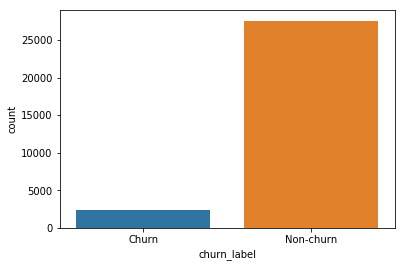

In [23]:
# creating labels for churn an non-churn visualizing the proportion of churners and non-churners in the data
target_count = df_high_val_cust.churn.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

df_high_val_cust['churn_label'] = df_high_val_cust['churn']
df_high_val_cust['churn_label'].replace([0, 1], ['Non-churn', 'Churn'], inplace = True)

sns.countplot("churn_label",data=df_high_val_cust)
plt.show()

**Class imbalance between 'churn' and 'non-churn' can be clearly seen in the above plots and statistics!**

In [24]:
#Let us drop the churn_label variable now

df_high_val_cust.drop(['churn_label'], axis=1, inplace=True)

#### Eliminate all columns in churn phase (9th month) as specified in the problem statement

In [25]:
#Remove All 9th Month related columns
drop_cols = [col for col in df_high_val_cust.columns if '_9' in col]
print(drop_cols)

df_high_val_cust.drop(drop_cols, axis=1, inplace=True)

df_high_val_cust.shape

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'max_rech_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'vbc_3g_9', 'total_rech_data_amt_9']


(30001, 87)

In [26]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 6 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
        plt.rcParams.update({'font.size': 20})
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [27]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = "Telecom Churn"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [28]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


#### Distribution graphs (histogram/bar graph) of sampled columns

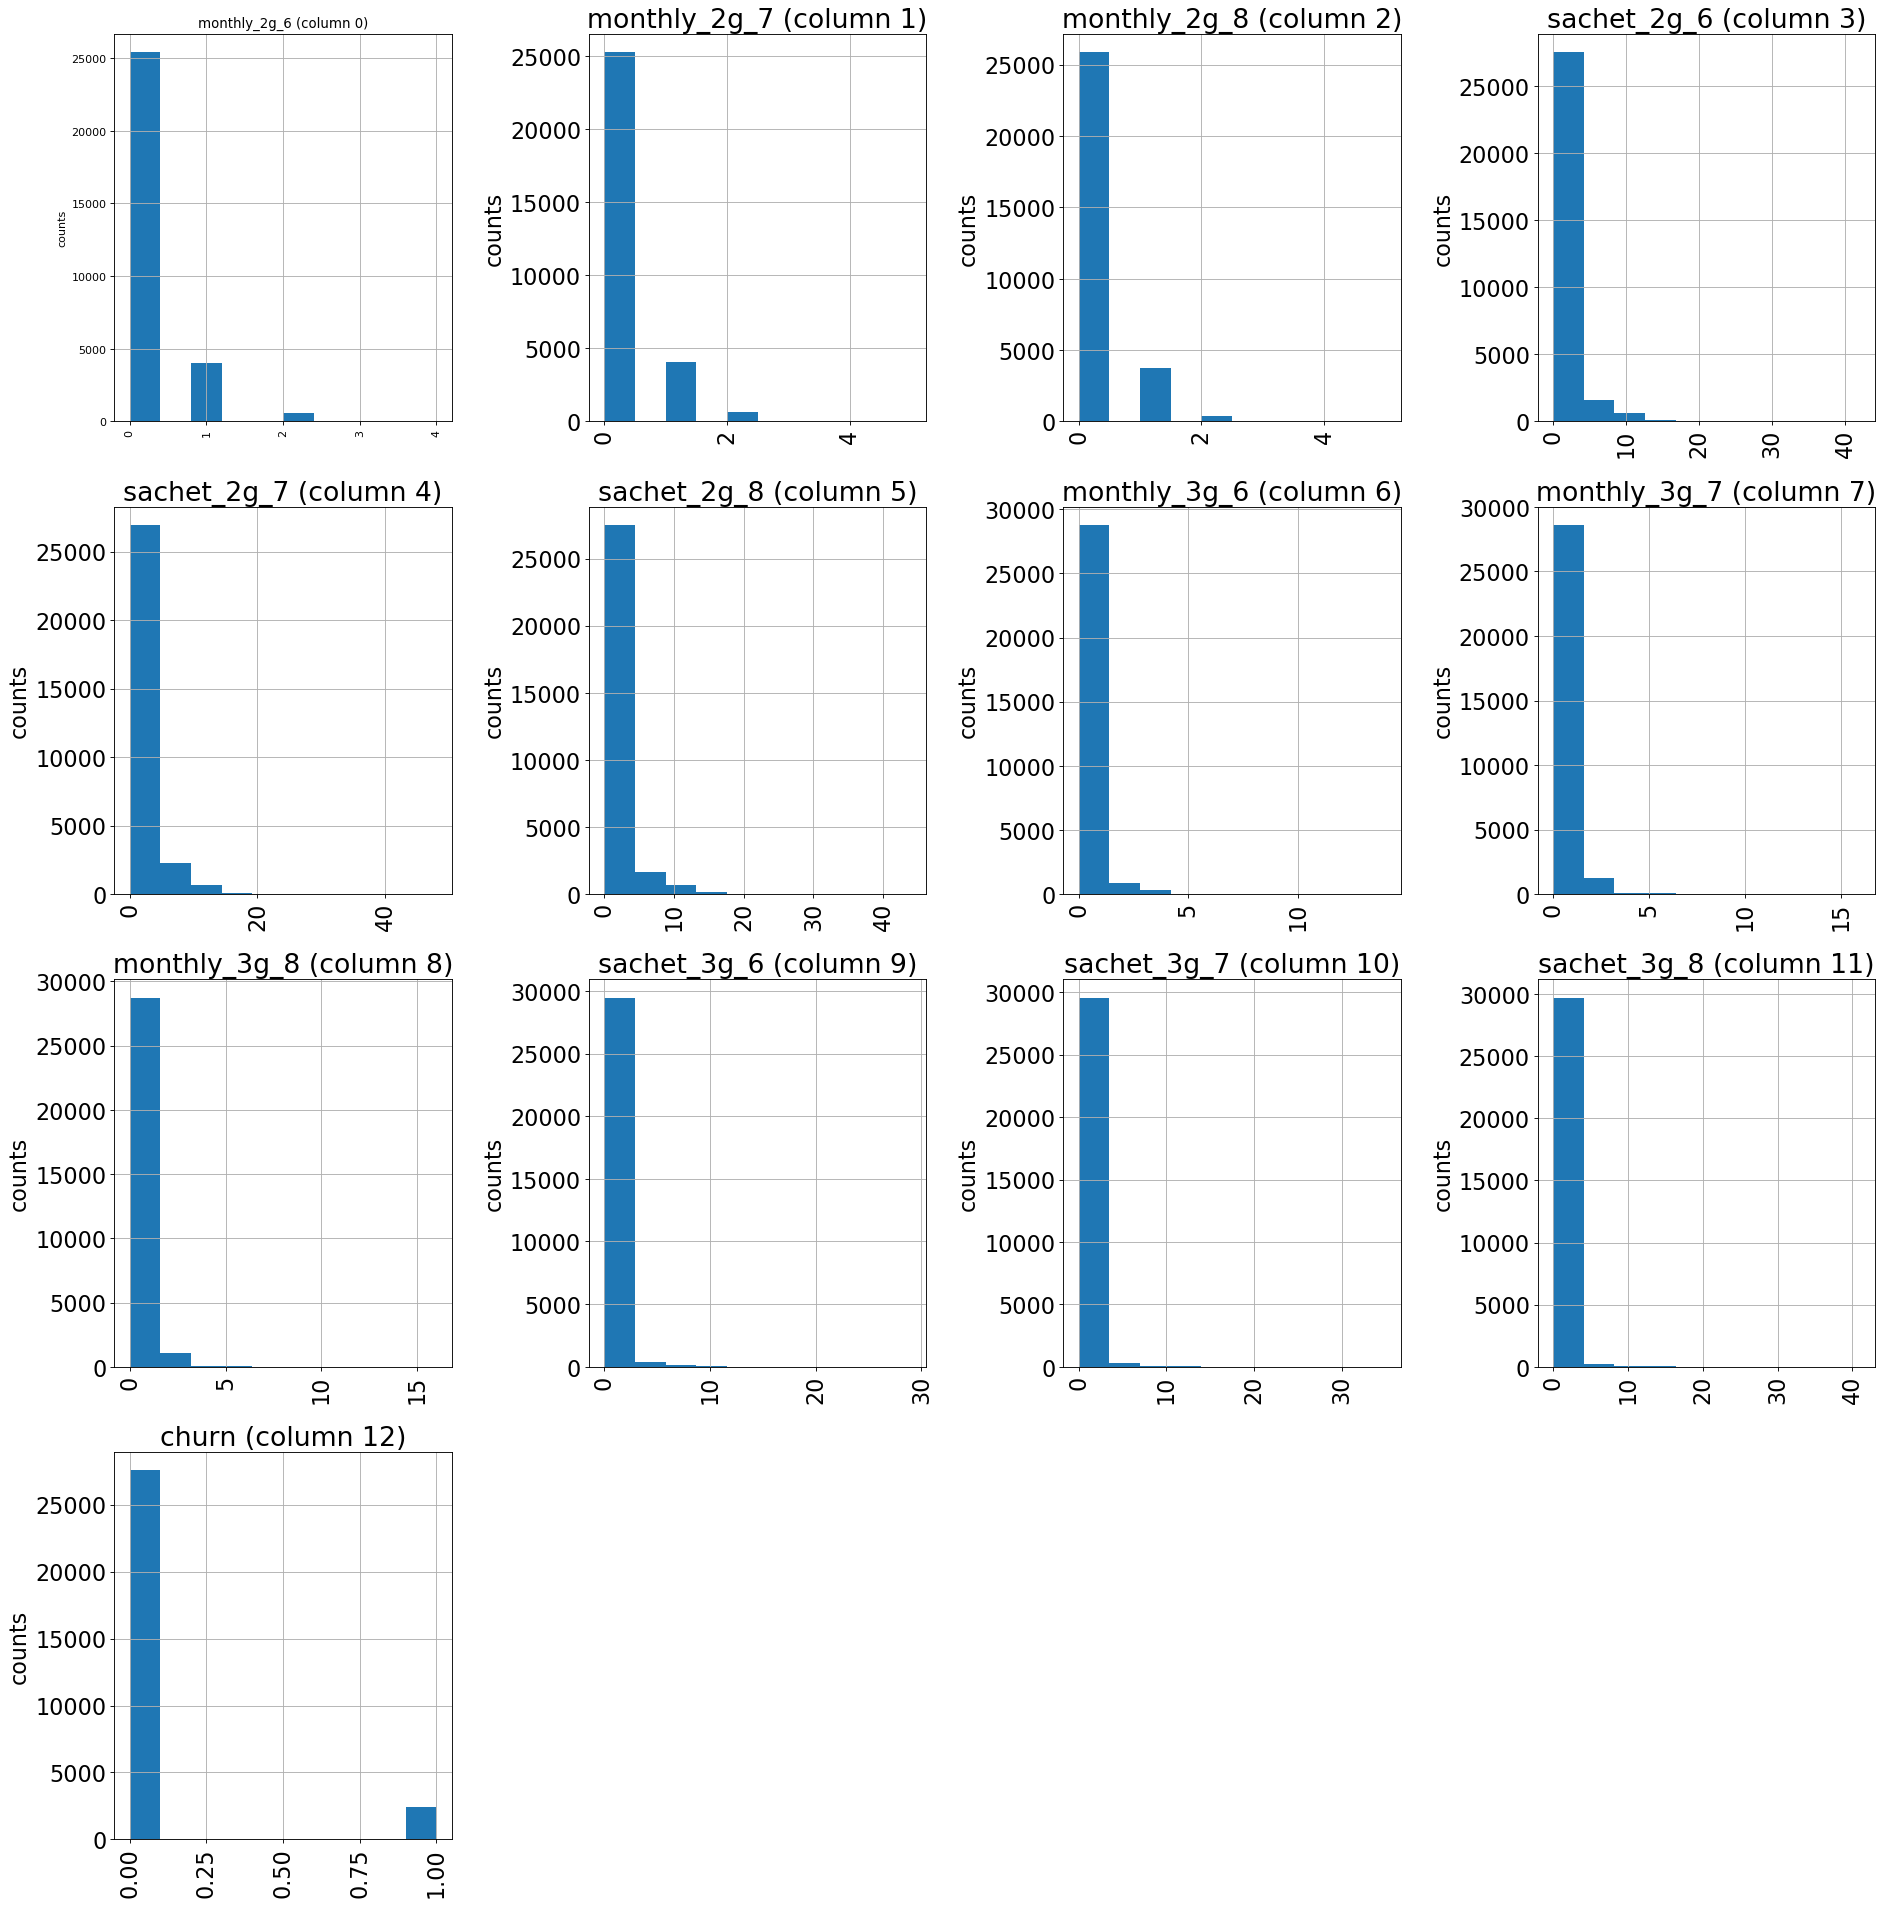

In [29]:
plotPerColumnDistribution(df_high_val_cust, 20, 4)

#### Correlation matrix

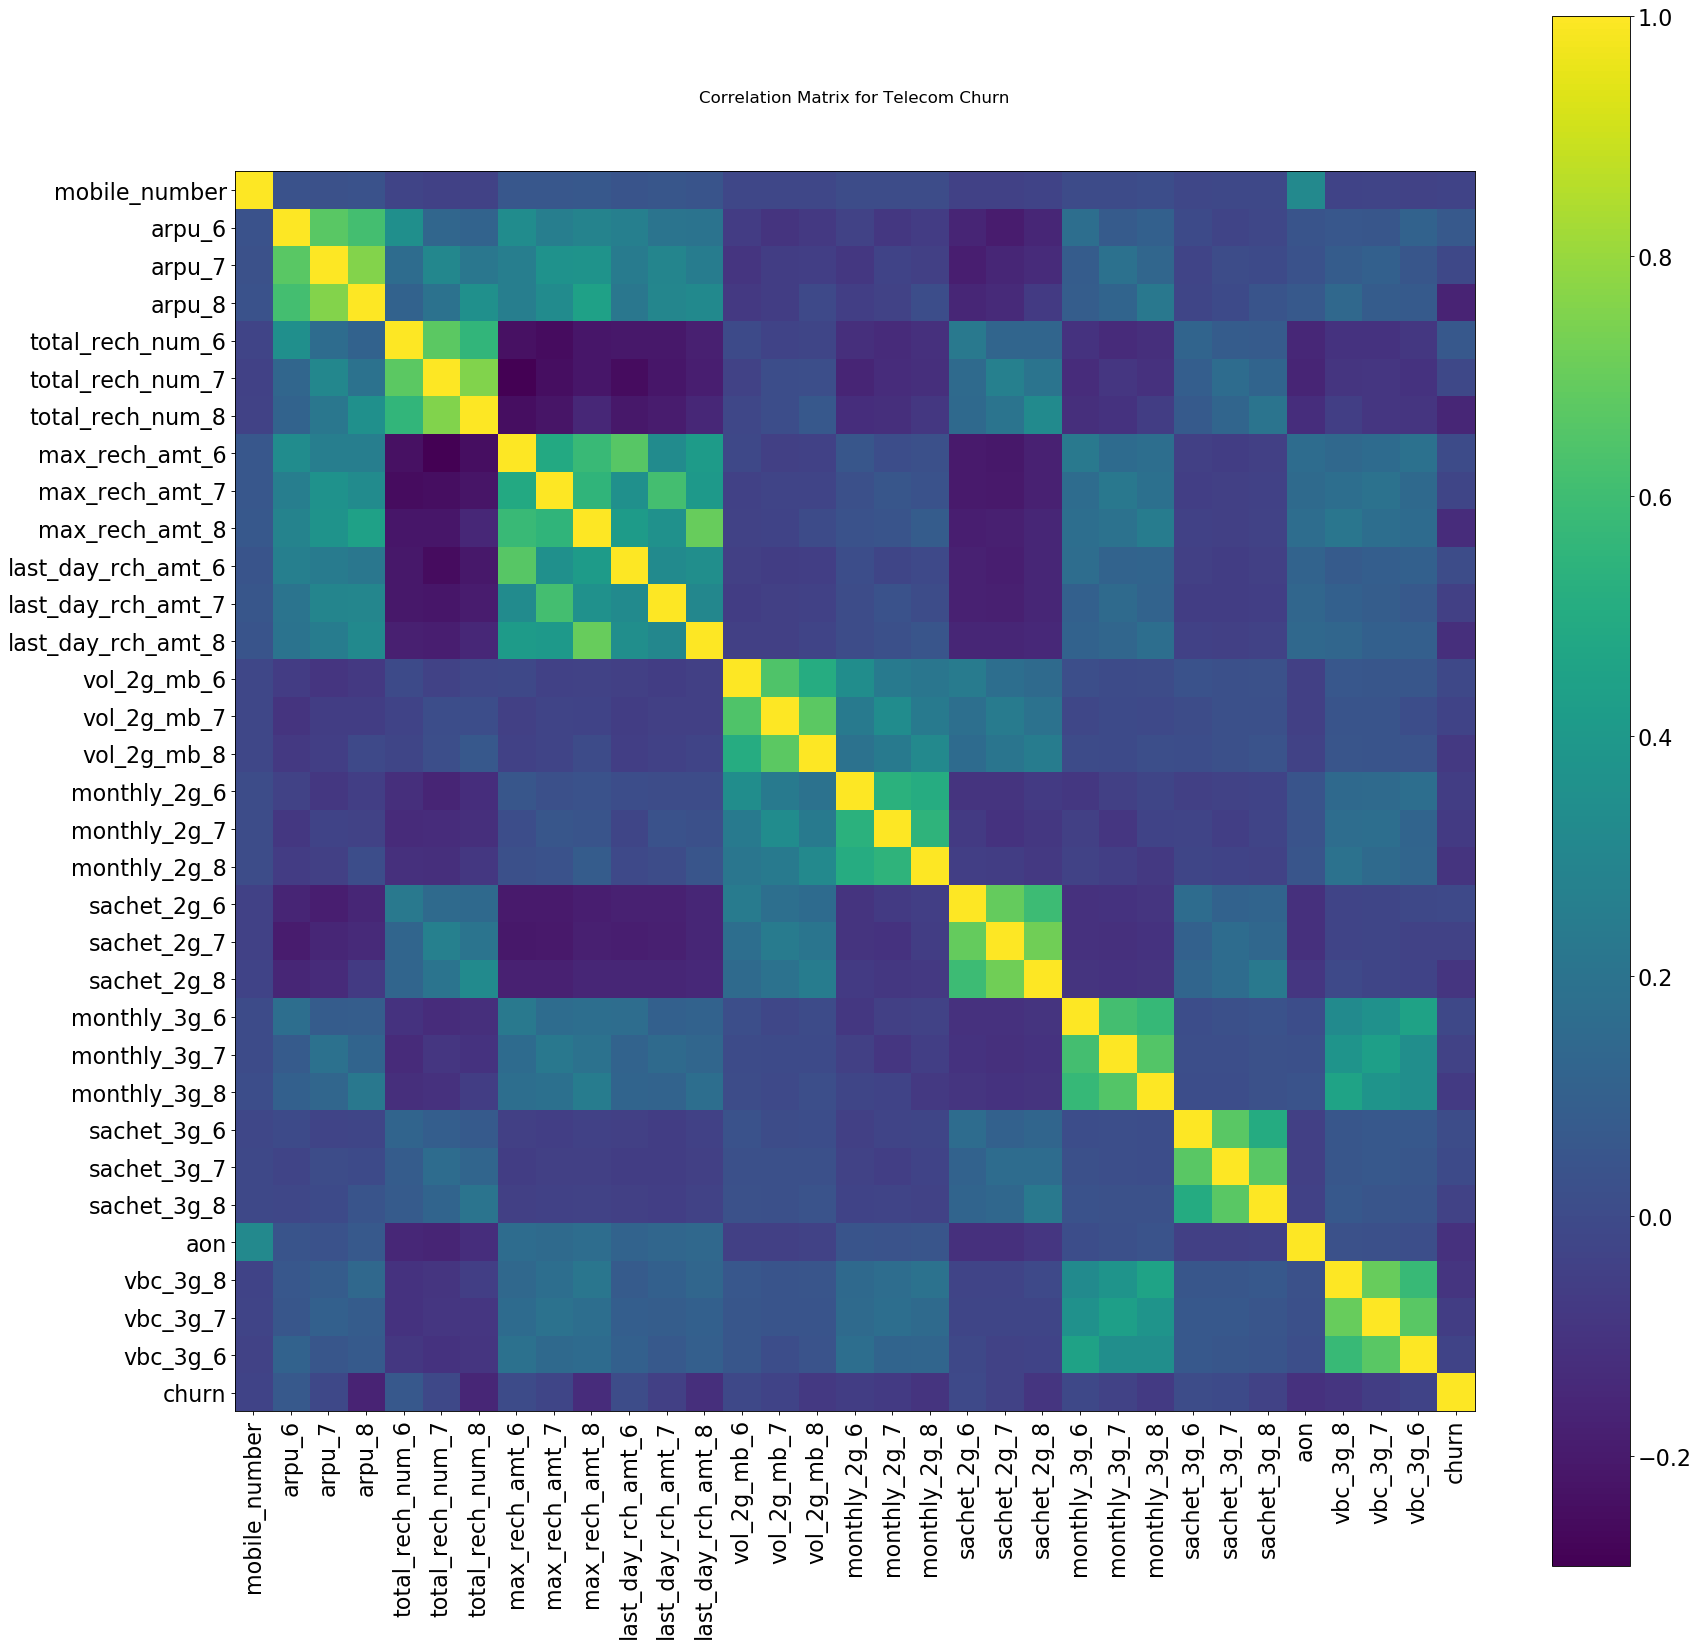

In [30]:
plotCorrelationMatrix(df_high_val_cust, 25)

#### Scatter and density plots:

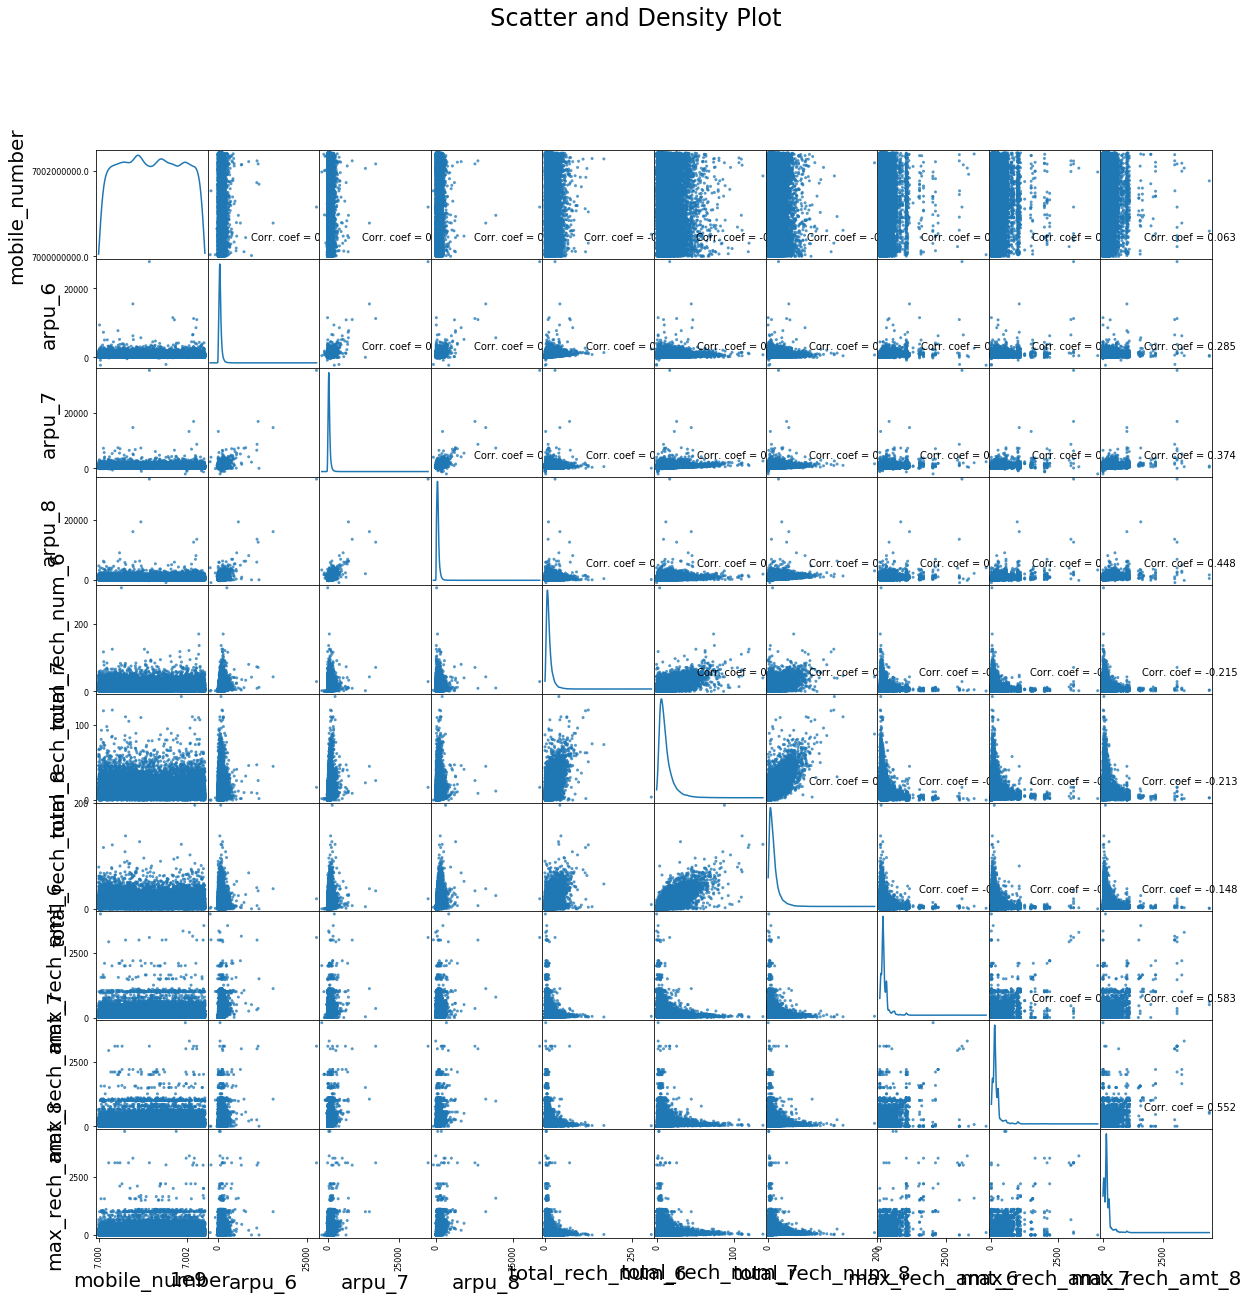

In [31]:
plotScatterMatrix(df_high_val_cust, 20, 10)

### Reduce the No of Columns by Creating New Meaningful Features

Create Columns with Average of 6th & 7th Month Since it's a "Good" Phase and Keep the 8th month untouched as it's "Action" Phase, for now to see if it can give any additional insight

In [32]:
col_list = df_high_val_cust.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (df_high_val_cust.shape)

for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    df_high_val_cust[avg_col_name] = (df_high_val_cust[col_6]  + df_high_val_cust[col_7])/ 2

(30001, 87)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2c_mou
loc_og_mou
std_og_t2f_mou
std_og_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_mou
std_ic_t2t_mou
std_ic_t2f_mou
std_ic_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
max_rech_amt
last_day_rch_amt
vol_2g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
vbc_3g


In [33]:
print(" Before dropping :" , df_high_val_cust.shape)

col_list = df_high_val_cust.filter(regex='_6|_7').columns

df_high_val_cust.drop(col_list, axis=1, inplace=True)
print(" After dropping :" , df_high_val_cust.shape)

 Before dropping : (30001, 115)
 After dropping : (30001, 59)


In [34]:
df_high_val_cust.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,...,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,nan,3.50,252.00,252.00,15.72,0.00,0.00,1.00,0.00,50.60
7,7000701601,3171.48,52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,...,15.46,5.00,1185.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06
8,7001524846,137.36,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,...,0.00,20.00,122.00,25.00,178.00,0.50,0.50,0.00,0.00,516.40
21,7002124215,637.76,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,...,0.00,24.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00
23,7000887461,366.97,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,...,2.67,4.00,89.50,89.50,0.24,0.00,0.00,1.00,0.00,25.93


In [35]:
#Conevrt AON in Months
df_high_val_cust['aon_mon'] = df_high_val_cust['aon']/30
df_high_val_cust.drop('aon', axis=1, inplace=True)
df_high_val_cust['aon_mon'].head()

0    32.27
7    26.73
8    10.50
21   24.00
23   20.13
Name: aon_mon, dtype: float64

Text(0.5,1,'Churn Distribution')

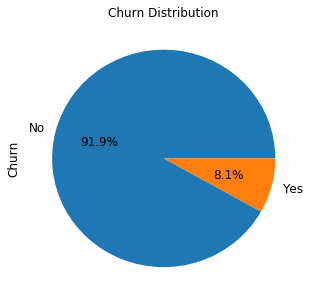

In [36]:
#Churn Distribution
ax = (df_high_val_cust['churn'].value_counts()*100.0 /len(df_high_val_cust)).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           

ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('Churn Distribution', fontsize = 12)

In our data, 91% of the customers do not churn. Clearly the data is skewed as we would expect a large majority of the customers to not churn. This is important to keep in mind for our modelling as skeweness could lead to a lot of false negatives. We will see in the modelling section on how to avoid skewness in the data.

#### Distribution graphs (histogram/bar graph) of sampled columns:

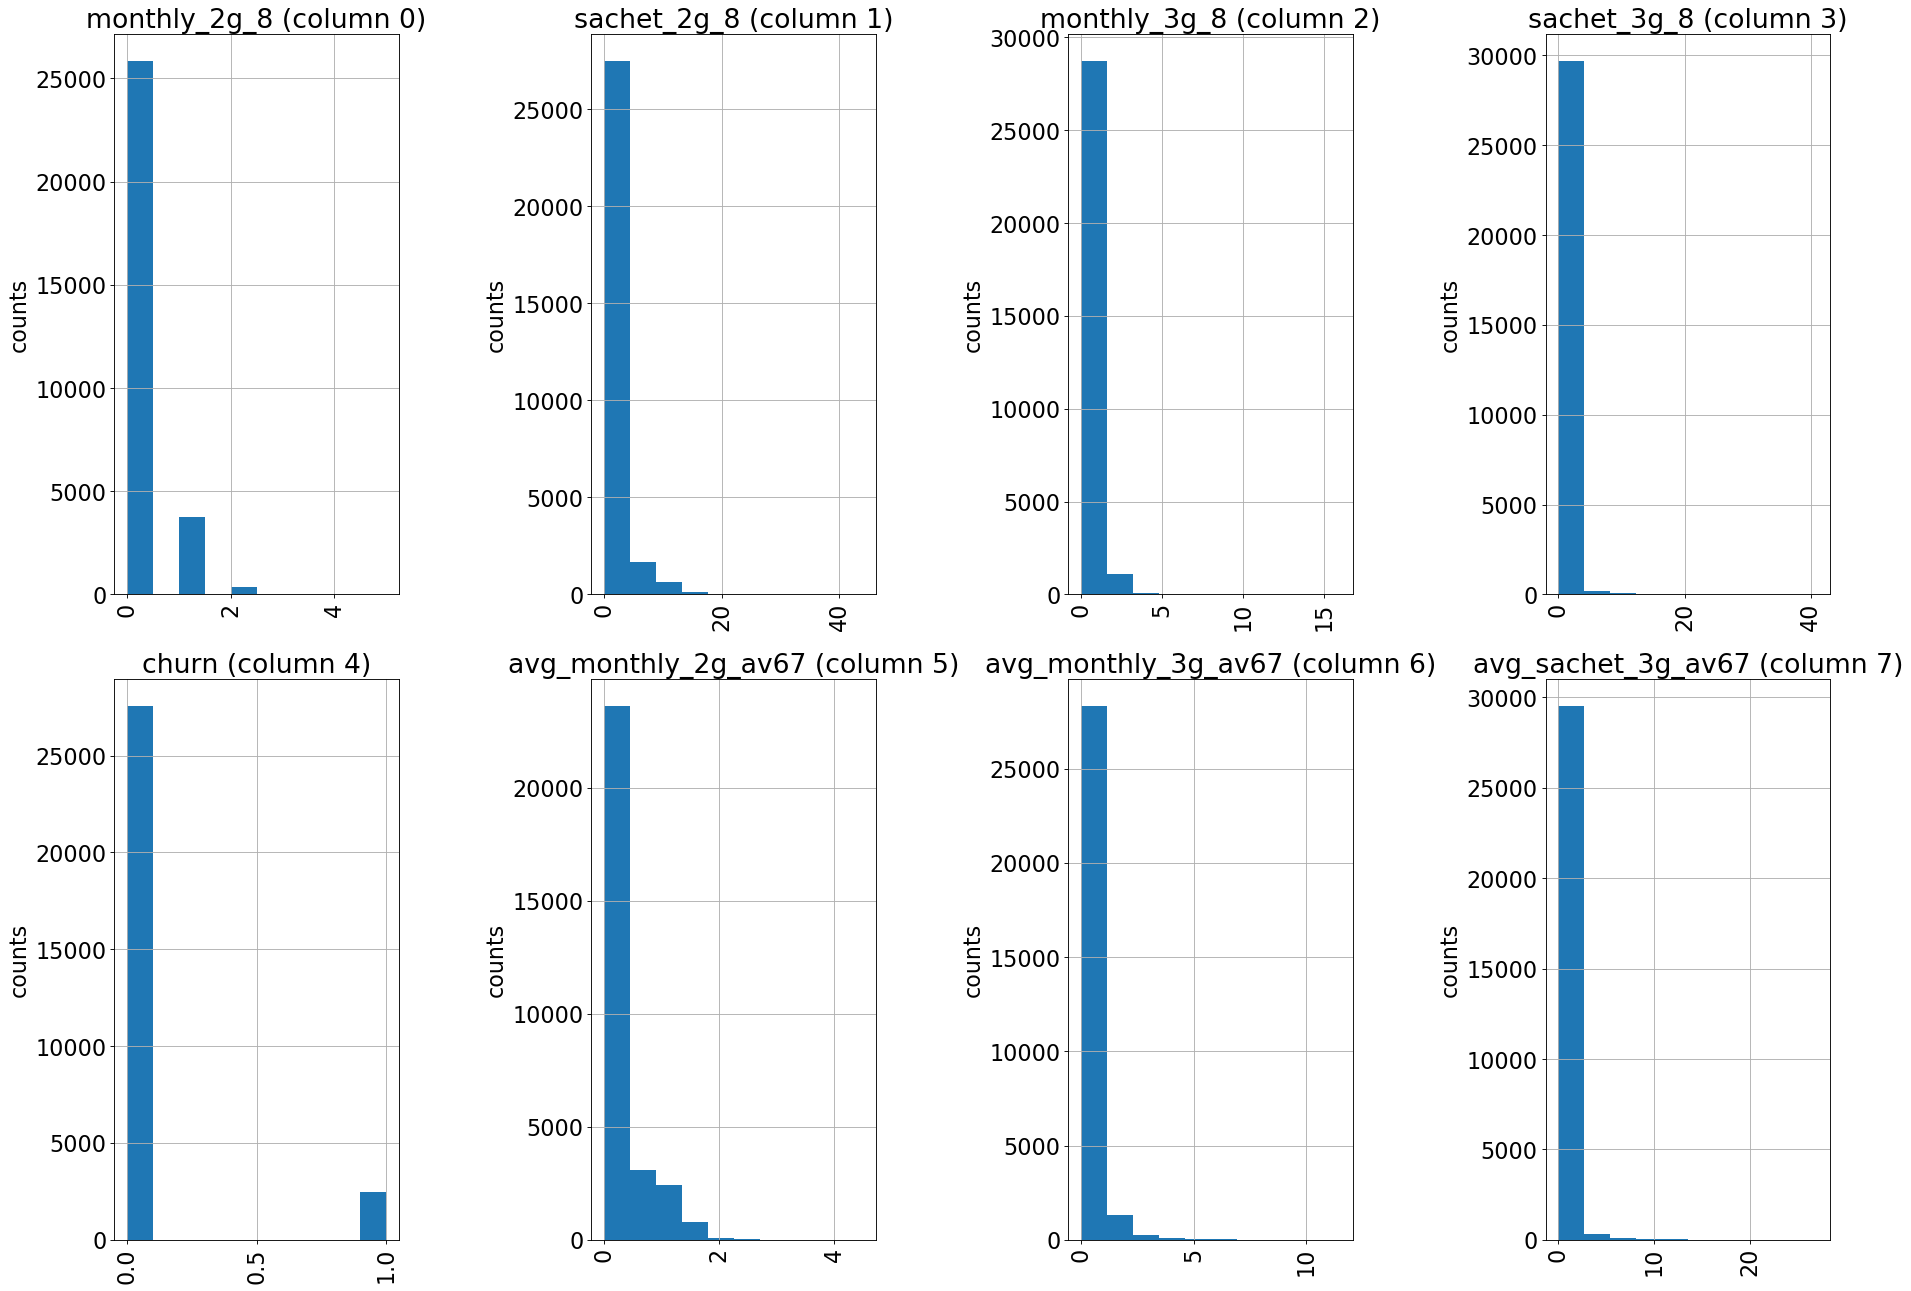

In [37]:
plotPerColumnDistribution(df_high_val_cust, 20, 4)

#### Correlation matrix:

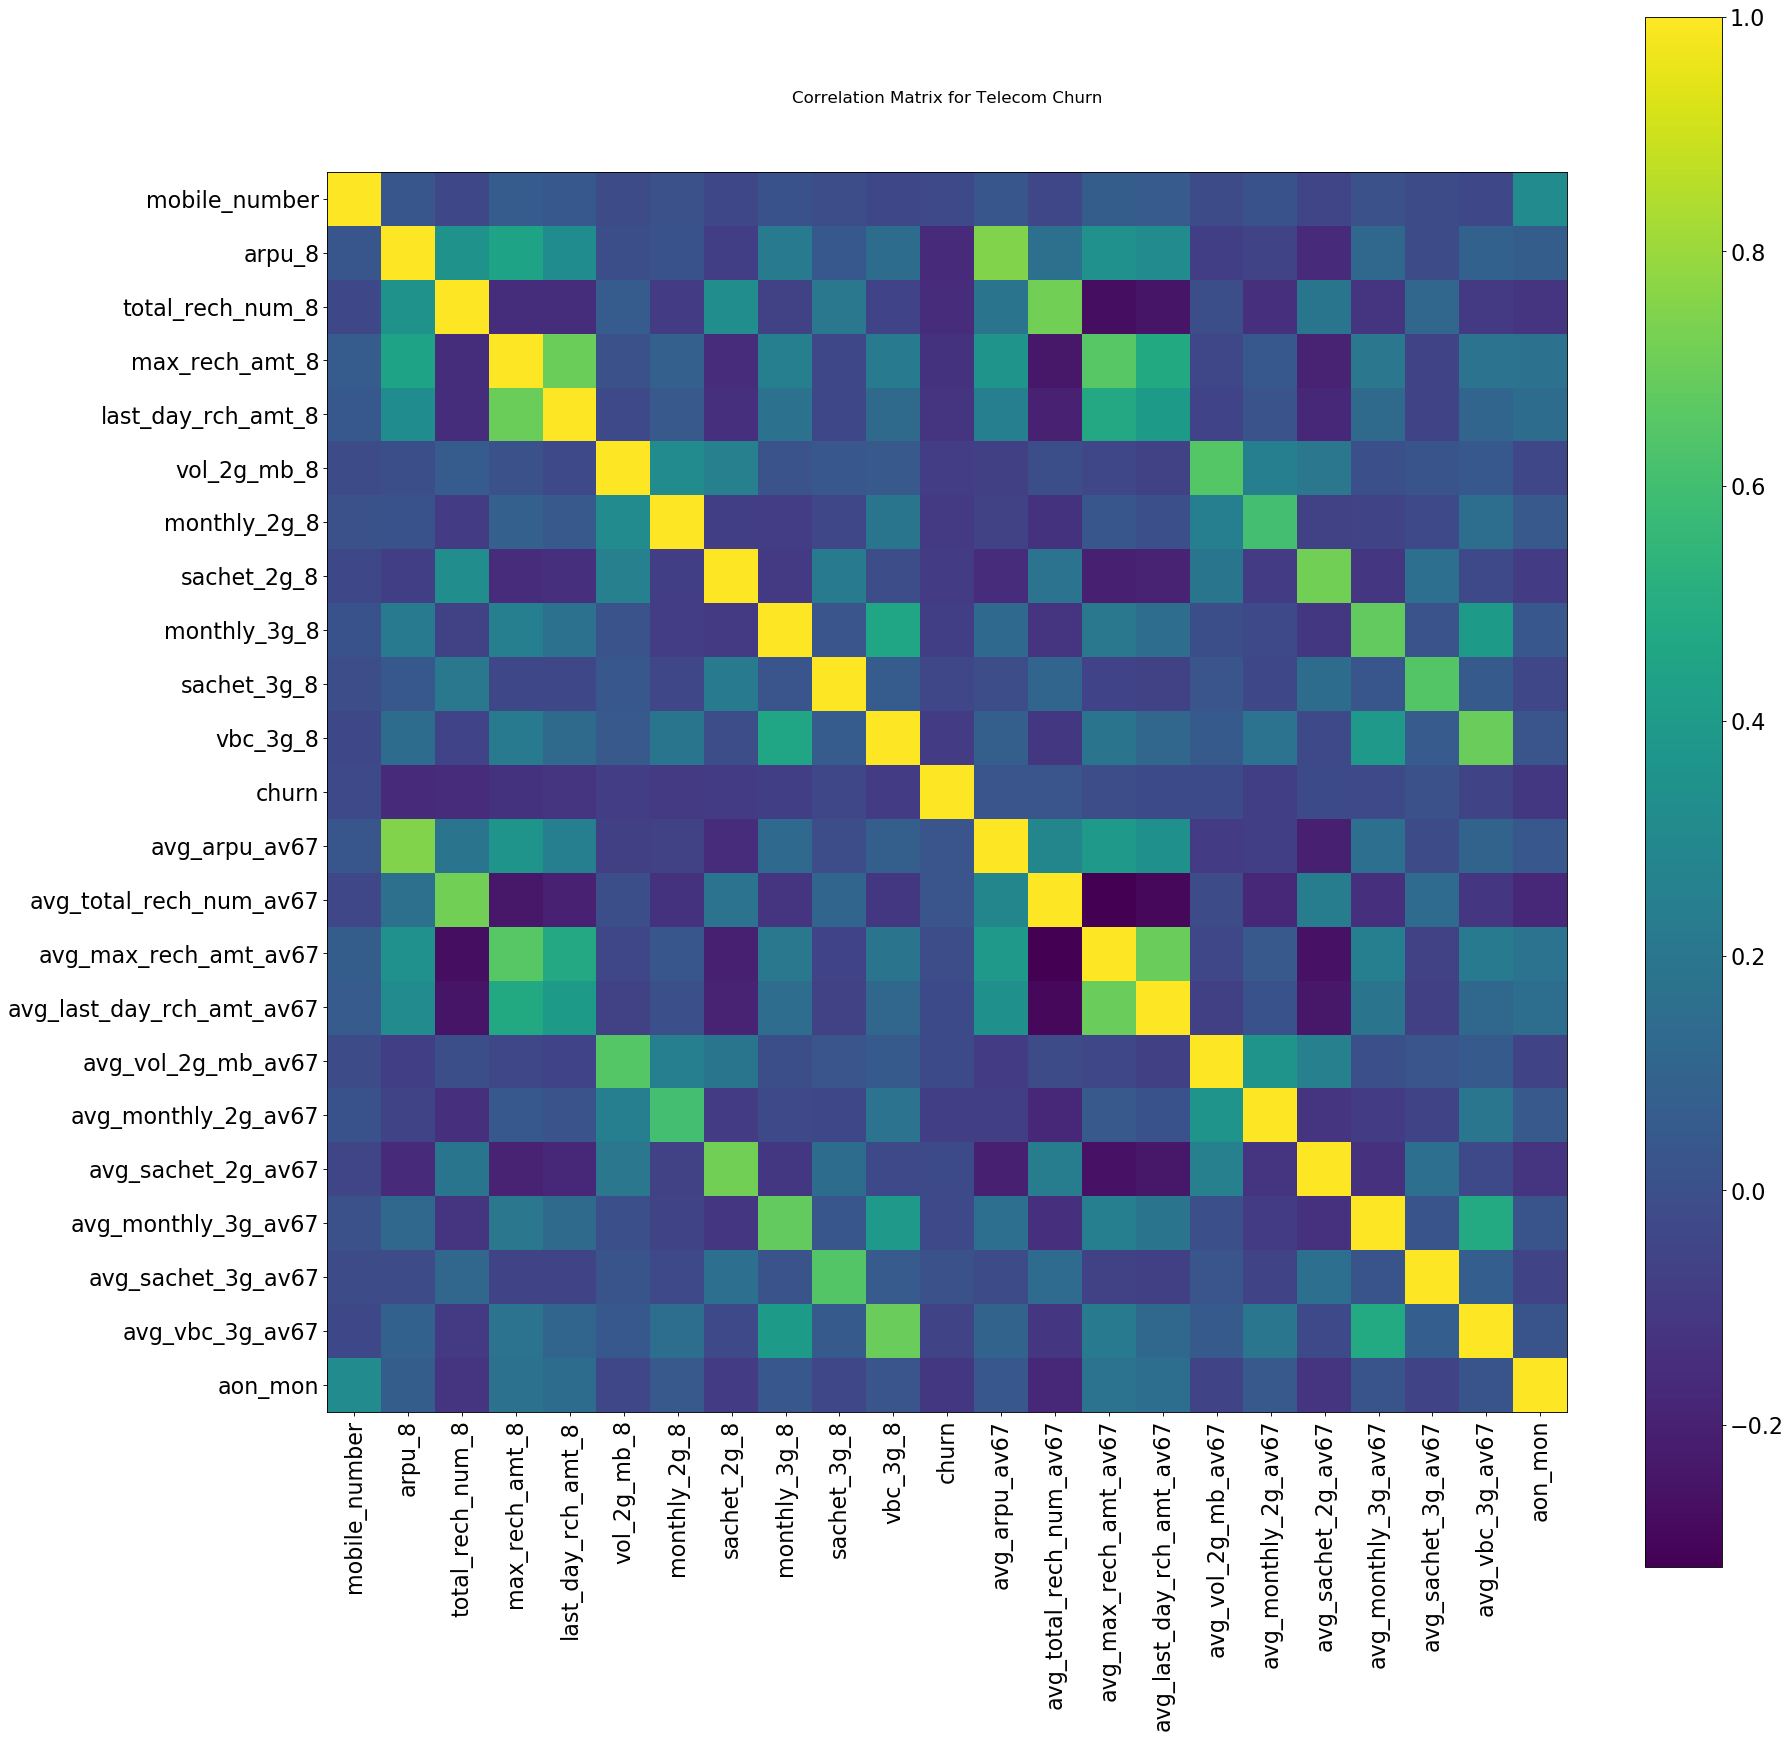

In [38]:
plotCorrelationMatrix(df_high_val_cust, 25)

#### Scatter and density plots:

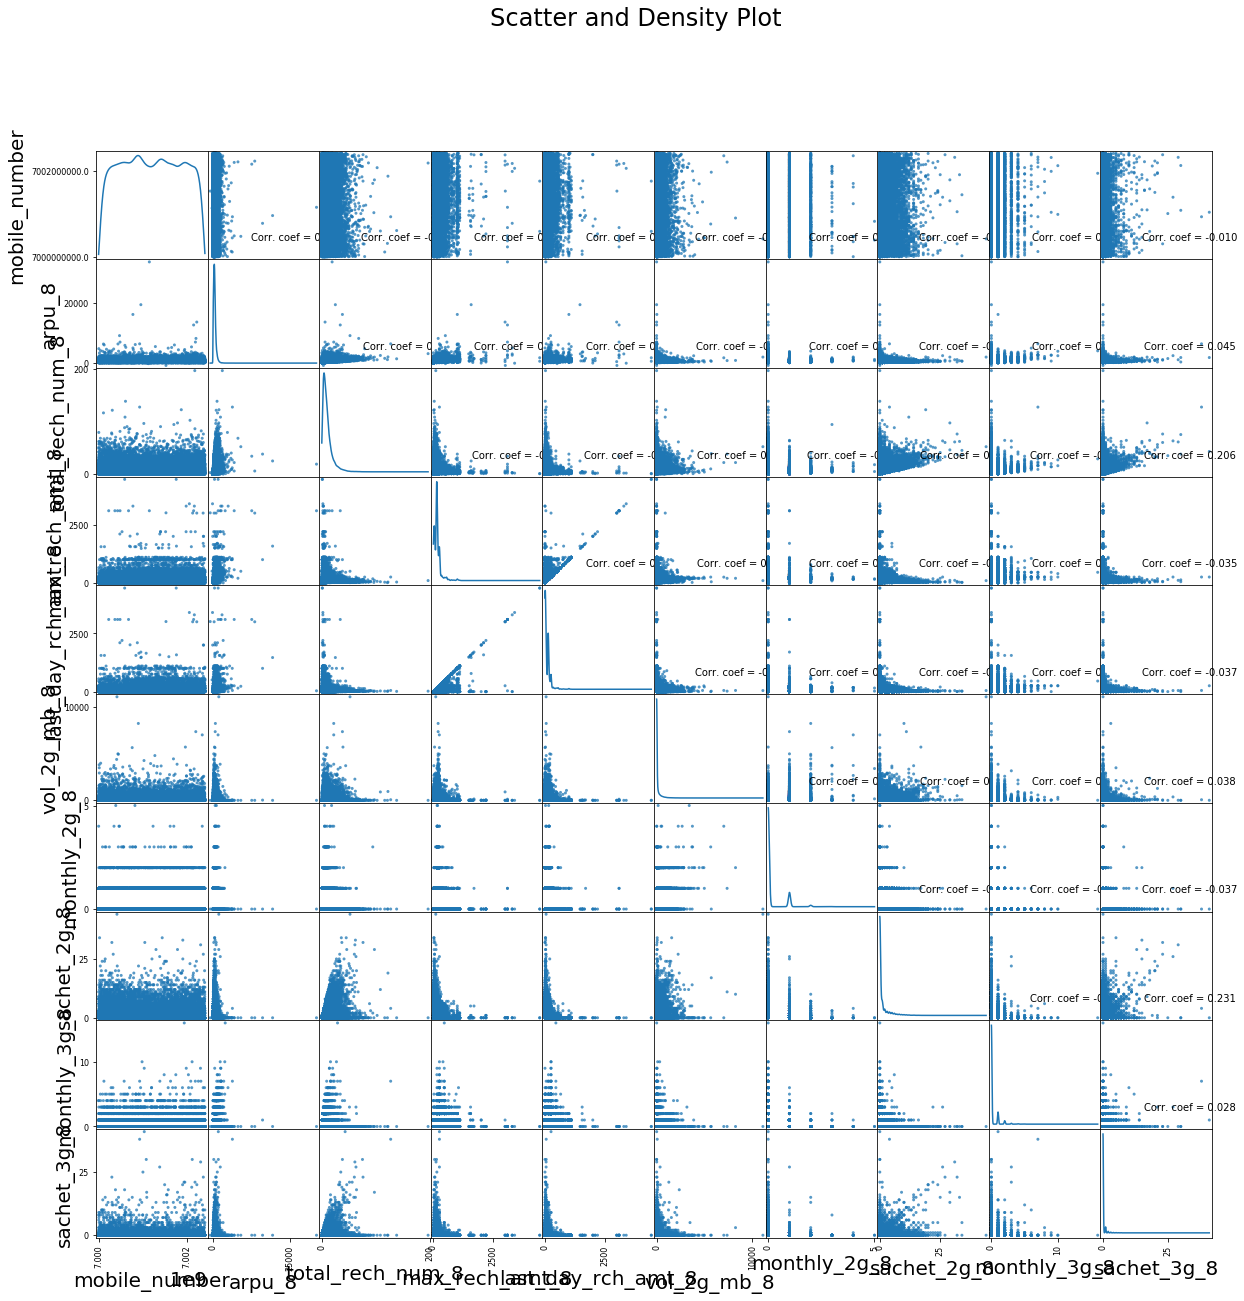

In [39]:
plotScatterMatrix(df_high_val_cust, 20, 10)

Text(0.5,1,'Customers by their tenure')

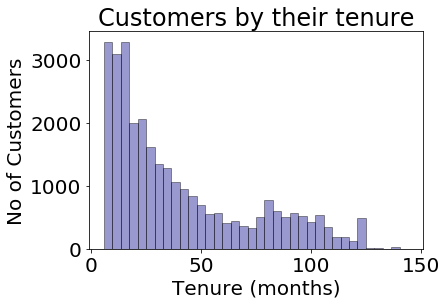

In [40]:
ax = sns.distplot(df_high_val_cust['aon_mon'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('No of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Customers by their tenure')

In [41]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
df_high_val_cust['tenure_range'] = pd.cut(df_high_val_cust['aon_mon'], tn_range, labels=tn_label)
df_high_val_cust['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): [0-6 Months < 6-12 Months < 1-2 Yrs < 2-5 Yrs < 5 Yrs and above]

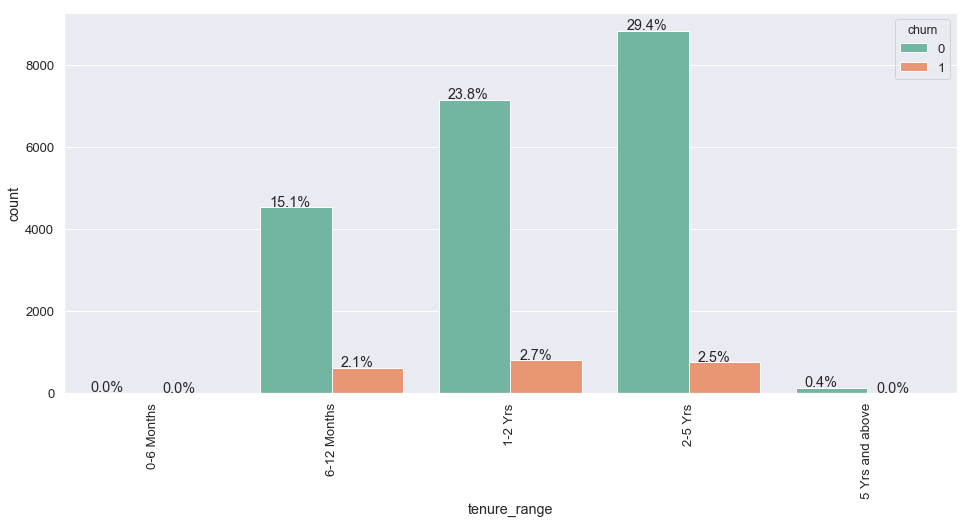

In [42]:
sns.set()
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

temp = pd.Series(data = 'tenure_range')
fig, ax = plt.subplots()
width = len(df_high_val_cust['tenure_range'].unique()) + 6 + 4*len(temp.unique())
fig.set_size_inches(width , 7)

total = float(len(df_high_val_cust.index))
ax = sns.countplot(x="tenure_range", data=df_high_val_cust, palette="Set2", hue = "churn");
for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(df_high_val_cust))), (p.get_x()+0.05, p.get_height()+20))
plt.xticks(rotation=90)
plt.show()

### Correlation of "Churn" with other variables:

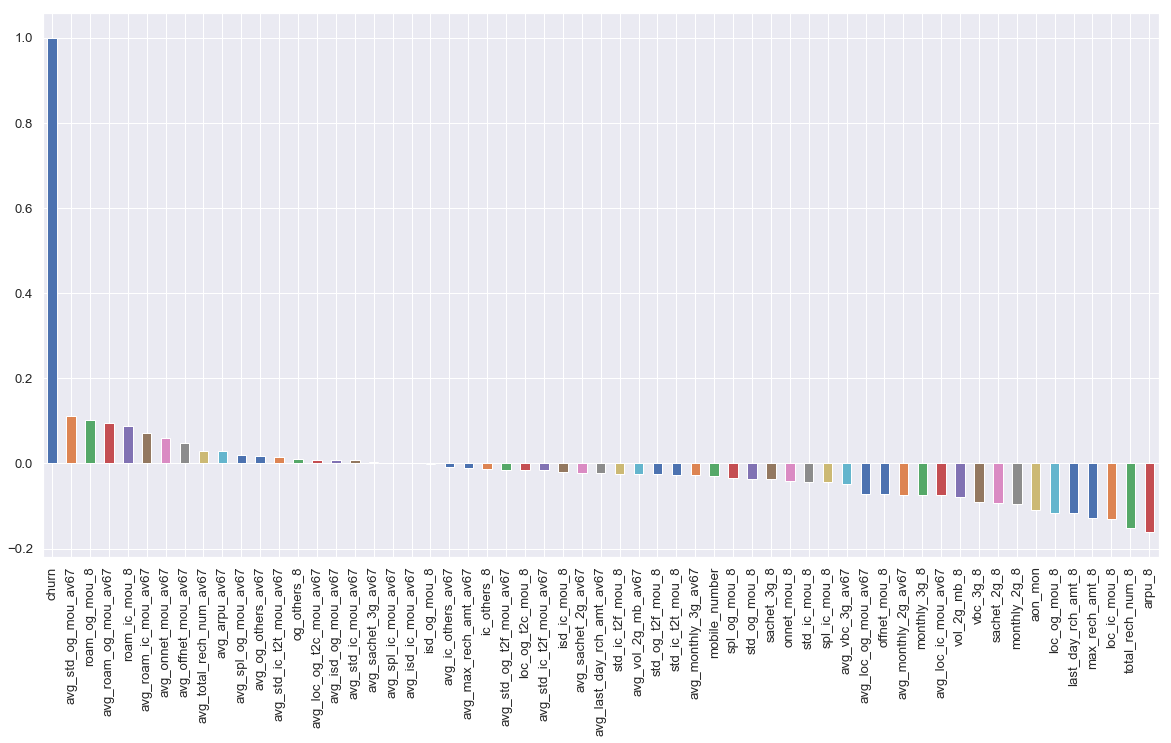

In [43]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(20,10))
df_high_val_cust.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

**Avg STD Outgoing Calls for Month 6 & 7, Outgoing calls in Roaming seems to be positively correlated with Churn while Avg Revenue, No Of Recharge for 8th Month seems negatively correlated.**

#### Lets look at the relation between total recharge in 8th Month Vs Average Revenue in 8th Month

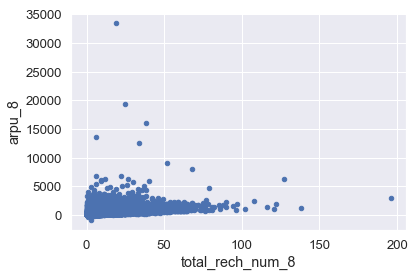

In [44]:
df_high_val_cust[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8', y='arpu_8')

#### Lets look at the relation between Tenure And Revenue

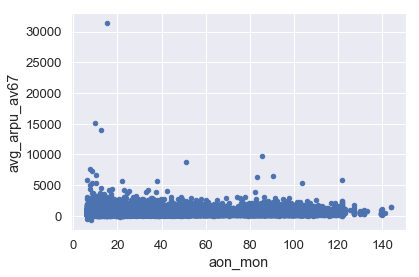

In [45]:
df_high_val_cust[['aon_mon', 'avg_arpu_av67']].plot.scatter(x = 'aon_mon',
                                                              y='avg_arpu_av67')

Finally, let's take a look at out predictor variable (Churn) and understand its interaction with other important variables as was found out in the correlation plot.

#### Churn vs Tenure 

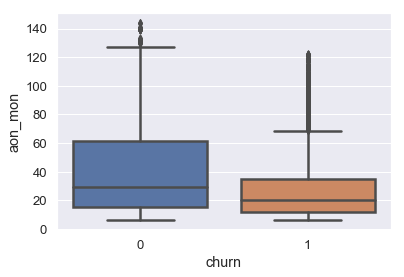

In [46]:
sns.boxplot(x = df_high_val_cust.churn, y = df_high_val_cust.aon_mon)

**As we can see form the below plot, the customers who do not churn, they tend to stay for a longer tenure with the telecom company.**

#### Churn Vs Volume based cost

Text(0.5,1,'Distribution of Volume based cost by churn')

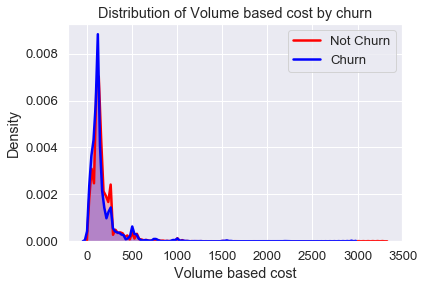

In [47]:
ax = sns.kdeplot(df_high_val_cust.avg_max_rech_amt_av67[(df_high_val_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(df_high_val_cust.avg_max_rech_amt_av67[(df_high_val_cust["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Volume based cost by churn')

**There is no visible difference in Volume Based Cost & Churn**

#### Churn Vs Max Recharge Amount

Text(0.5,1,'Distribution of Max Recharge Amount by churn')

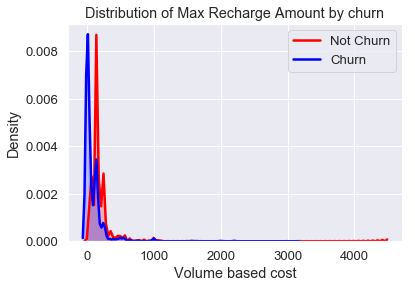

In [48]:
ax = sns.kdeplot(df_high_val_cust.max_rech_amt_8[(df_high_val_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(df_high_val_cust.max_rech_amt_8[(df_high_val_cust["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Max Recharge Amount by churn')

**People Who Recharge with less Amount are more likely to Churn**

In [49]:
df_high_val_cust.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,...,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,aon_mon,tenure_range
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,252.00,252.00,15.72,0.00,0.00,1.00,0.00,50.60,32.27,2-5 Yrs
7,7000701601,3171.48,52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,...,1185.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,26.73,2-5 Yrs
8,7001524846,137.36,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,...,122.00,25.00,178.00,0.50,0.50,0.00,0.00,516.40,10.50,6-12 Months
21,7002124215,637.76,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,...,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,24.00,1-2 Yrs
23,7000887461,366.97,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,...,89.50,89.50,0.24,0.00,0.00,1.00,0.00,25.93,20.13,1-2 Yrs


### Outlier Treatment by capping using 3 times Std Dev

In [50]:
def outlier_cap(num_cols):
    upper_limit = num_cols.mean() + 3*num_cols.std()
    lower_limit = num_cols.mean() - 3*num_cols.std()
    num_cols[num_cols<lower_limit] = lower_limit
    num_cols[num_cols>upper_limit] = upper_limit
    return num_cols

In [51]:
#select the numeric cols for outlier capping
df_num_cols = df_high_val_cust.select_dtypes(include='number')
df_num_cols.shape

(30001, 59)

In [53]:
#remove mobile number and churn from the numeric cols as these need not be capped
num_cols = list(df_num_cols.columns)
num_cols.remove('churn')
num_cols.remove('mobile_number')
len(num_cols)

57

In [54]:
# cap outliers in the numeric columns
df_high_val_cust[num_cols] = df_high_val_cust[num_cols].apply(outlier_cap, axis=0)

Text(0.5,1,'Distribution of Max Recharge Amount by churn')

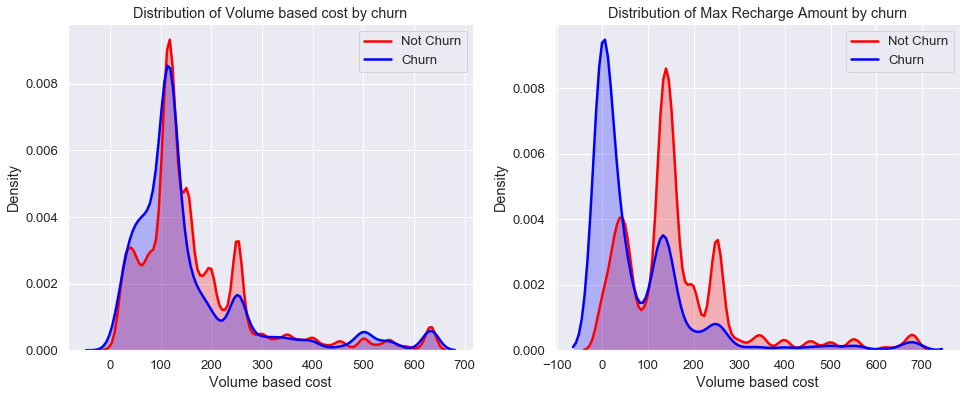

In [55]:
# Relooking at 1) Churn Vs Volume based cost and 2) Churn Vs Max Recharge Amount

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
ax = sns.kdeplot(df_high_val_cust.avg_max_rech_amt_av67[(df_high_val_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(df_high_val_cust.avg_max_rech_amt_av67[(df_high_val_cust["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Volume based cost by churn')

plt.subplot(1,2,2)
ax = sns.kdeplot(df_high_val_cust.max_rech_amt_8[(df_high_val_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(df_high_val_cust.max_rech_amt_8[(df_high_val_cust["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Max Recharge Amount by churn')

## Model Building

In [56]:
# Creating a dataframe to store the consolidated results of all the models
model_summary_consol = pd.DataFrame()

In [57]:
#Lets Create New DF for Model Building

df = df_high_val_cust[:].copy()

#Dropping tenure_range since we have AON MONTH already and columns are highly coorelated
df.drop('tenure_range', axis=1, inplace=True)
df.drop('mobile_number', axis=1, inplace=True)

#Since All The Values are realted to Price/ Cost/ Amount, Filling NaN with 0

df.fillna(0, inplace=True)

df.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,...,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,aon_mon
0,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.50,252.00,252.00,15.72,0.00,0.00,1.00,0.00,50.60,32.27
7,2014.48,52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,10.01,...,5.00,633.32,0.00,0.00,0.00,0.00,0.00,0.00,19.06,26.73
8,137.36,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,0.00,...,20.00,122.00,25.00,178.00,0.50,0.50,0.00,0.00,516.40,10.50
21,637.76,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,0.00,...,24.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,24.00
23,366.97,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,0.00,...,4.00,89.50,89.50,0.24,0.00,0.00,1.00,0.00,25.93,20.13


In [58]:
X = df.drop(['churn'], axis=1)
y = df['churn']
df.drop('churn', axis=1, inplace=True)

In [59]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [60]:
# Split in train & Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

In [61]:
print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)

y_train_imb = (y_train != 0).sum()/(y_train == 0).sum()
y_test_imb = (y_test != 0).sum()/(y_test == 0).sum()
print("Imbalance in Train Data : ", y_train_imb)
print("Imbalance in Test Data : ", y_test_imb)

X_train Shape :  (21000, 57)
X_test Shape :  (9001, 57)
Imbalance in Train Data :  0.08875985068436333
Imbalance in Test Data :  0.08812862669245648


In [62]:
# Balancing DataSet
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_tr,y_tr = sm.fit_resample(X_train,y_train)

In [63]:
print("X_tr Shape", X_tr.shape)
print("y_tr Shape", y_tr.shape)

imb = (y_tr != 0).sum()/(y_tr == 0).sum()
print("Imbalance in Train Data : ",imb)

X_tr Shape (38576, 57)
y_tr Shape (38576,)
Imbalance in Train Data :  1.0


#### Reccursive Feature Elimination - RFE

In [64]:
# Feature reduction using RFE
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
from sklearn.feature_selection import RFE

# running RFE with 15 variables as output
rfe = RFE(lr, 15)   
rfe = rfe.fit(X_tr, y_tr)

In [65]:
rfe_features = list(df.columns[rfe.support_])
print("Features identified by RFE ", rfe_features)

Features identified by RFE  ['loc_og_mou_8', 'std_og_mou_8', 'og_others_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'vbc_3g_8', 'avg_arpu_av67', 'avg_loc_ic_mou_av67']


In [66]:
X_rfe = pd.DataFrame(data=X_tr).iloc[:, rfe.support_]
y_rfe = y_tr

### Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)
lr.fit(X_rfe, y_rfe)

LogisticRegression(random_state=1)

In [68]:
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]

y_pred = lr.predict(X_test_rfe)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6756 1516]
 [ 138  591]]


In [69]:
print('Accuracy of Logistic Regression Model on test set is ',lr.score(X_test_rfe, y_test))

Accuracy of Logistic Regression Model on test set is  0.8162426397066993


In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      8272
           1       0.28      0.81      0.42       729

    accuracy                           0.82      9001
   macro avg       0.63      0.81      0.65      9001
weighted avg       0.92      0.82      0.85      9001



In [71]:
# To get the weights of all the variables
weights = pd.Series(lr.coef_[0],
                 index=rfe_features)
weights.sort_values(ascending = False)

avg_arpu_av67          0.67
avg_loc_ic_mou_av67    0.40
vol_2g_mb_8           -0.30
monthly_3g_8          -0.33
std_og_mou_8          -0.33
std_ic_mou_8          -0.36
vbc_3g_8              -0.40
sachet_2g_8           -0.51
total_rech_num_8      -0.54
last_day_rch_amt_8    -0.58
monthly_2g_8          -0.61
spl_ic_mou_8          -0.66
og_others_8           -0.91
loc_og_mou_8          -0.97
loc_ic_mou_8          -1.73
dtype: float64

In [72]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred),2)

0.8162426397066993 2


In [73]:
from sklearn.metrics import precision_score, recall_score
model_summary_consol = model_summary_consol.append(pd.DataFrame([['Logistic Regression', round(accuracy_score(y_test,y_pred),2), round(recall_score(y_test,y_pred),2), round(precision_score(y_test,y_pred),2)]], columns = ['Model', 'Accuracy', 'Recall', 'Precision']),ignore_index=True)
model_summary_consol

,Model,Accuracy,Recall,Precision
0,Logistic Regression,0.82,0.81,0.28


LR Summary
* Model Accuracy is 82%
* Confusion matix clearly shows that the model has drawback in predicting churn as high false positives.

## Logistic Regression with PCA

### PCA (Principal Component Analysis)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

#Applying Smote
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(38576, 57)
(38576,)


In [75]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(random_state=100)

#Applying  PCA on the train data
pca.fit(X_tr)

PCA(random_state=100)

In [76]:
X_tr_pca = pca.fit_transform(X_tr)
print(X_tr_pca.shape)

X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

(38576, 57)
(9001, 57)


#### Applying logistic regression

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca = LogisticRegression(C=1e9)
lr_pca.fit(X_tr_pca, y_tr)

# Predicted probabilities
y_pred = lr_pca.predict(X_test_pca)

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))

[[6825 1447]
 [ 132  597]]


In [79]:
print("Logistic Regression accuracy with PCA: ",accuracy_score(y_test,y_pred))

Logistic Regression accuracy with PCA:  0.8245750472169759


In [80]:
col = list(df.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(10)

,Feature,PC1,PC2,PC3
0,arpu_8,0.33,0.06,-0.09
1,onnet_mou_8,0.18,-0.13,-0.09
2,offnet_mou_8,0.25,-0.05,-0.10
3,roam_ic_mou_8,0.18,-0.05,0.43
4,roam_og_mou_8,0.19,-0.09,0.43
5,loc_og_t2c_mou_8,0.06,-0.04,-0.07
6,loc_og_mou_8,0.18,0.10,-0.15
7,std_og_t2f_mou_8,0.07,0.08,-0.02
8,std_og_mou_8,0.19,-0.19,-0.12
9,isd_og_mou_8,0.07,0.08,-0.03


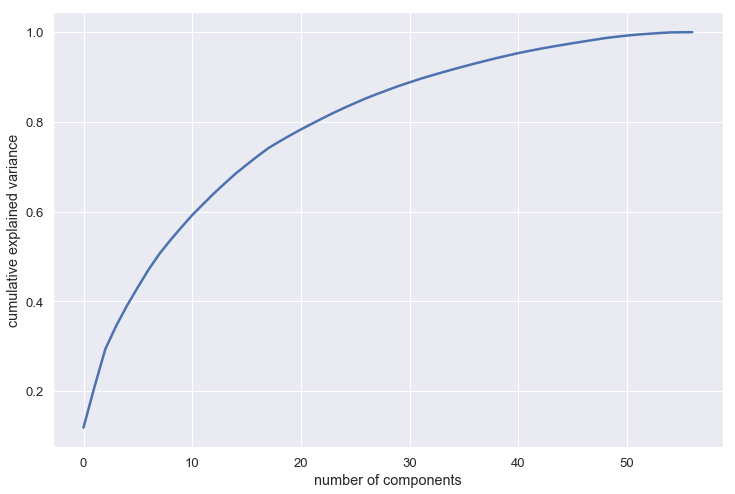

In [81]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [82]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 11.9 ,  20.87,  29.34,  34.54,  39.07,  43.19,  47.16,  50.67,
        53.68,  56.5 ,  59.24,  61.68,  64.08,  66.32,  68.51,  70.46,
        72.36,  74.17,  75.63,  77.02,  78.34,  79.6 ,  80.84,  82.04,
        83.17,  84.25,  85.29,  86.23,  87.13,  88.02,  88.83,  89.62,
        90.34,  91.04,  91.72,  92.37,  93.01,  93.62,  94.23,  94.8 ,
        95.34,  95.84,  96.3 ,  96.74,  97.15,  97.55,  97.94,  98.32,
        98.69,  98.98,  99.25,  99.48,  99.65,  99.81,  99.95,  99.99,
       100.01])

#### Applying Logistic Regression with 32 columns with 90% variance


In [83]:
pca_32 = PCA(n_components=32)

df_tr_pca_32 = pca_32.fit_transform(X_tr)
print(df_tr_pca_32.shape)

df_test_pca_32 = pca_32.transform(X_test)
print(df_test_pca_32.shape)

(38576, 32)
(9001, 32)


In [84]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca1 = LogisticRegression(C=1e9)
lr_pca1.fit(df_tr_pca_32, y_tr)

# Predicted probabilities
y_pred32 = lr_pca1.predict(df_test_pca_32)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred32)

In [85]:
model_summary_consol = model_summary_consol.append(pd.DataFrame([['Logistic Regression with PCA', round(accuracy_score(y_test,y_pred),2), round(recall_score(y_test,y_pred),2), round(precision_score(y_test,y_pred),2)]], columns = ['Model', 'Accuracy', 'Recall', 'Precision']),ignore_index=True)
model_summary_consol

,Model,Accuracy,Recall,Precision
0,Logistic Regression,0.82,0.81,0.28
1,Logistic Regression with PCA,0.82,0.82,0.29


### PCA Summary :
*  Model has 82% Accuracy
* 32 Features can obtain optimal accuracy with 90% Variance
* Main Features are arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8

## Decision Tress

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

#Applying Smote
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(38576, 57)
(38576,)


#### Feature reduction using LASSO

In [87]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
 
lsvc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_tr, y_tr)
model = SelectFromModel(lsvc, prefit=True)
X_lasso = model.transform(X_tr)
pos = model.get_support(indices=True)
 ### Feature reduction using RFE
print(X_lasso.shape)
print(pos)

(38576, 31)
[ 1  2  4  6  7  9 10 12 14 15 16 19 20 21 22 23 24 25 26 27 28 30 38 39
 40 41 43 47 50 51 56]


In [88]:
#feature vector for decision tree
lasso_features = list(df.columns[pos])
print("Features for LASSO model buidling: ", lasso_features)

Features for LASSO model buidling:  ['onnet_mou_8', 'offnet_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'loc_ic_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'vbc_3g_8', 'avg_arpu_av67', 'avg_offnet_mou_av67', 'avg_spl_og_mou_av67', 'avg_og_others_av67', 'avg_loc_ic_mou_av67', 'avg_std_ic_t2t_mou_av67', 'avg_std_ic_mou_av67', 'avg_total_rech_num_av67', 'avg_vol_2g_mb_av67', 'avg_monthly_2g_av67', 'aon_mon']


#### Decision Tree with Default Hyperparameter

In [89]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5)

In [90]:
# The evaluation metrics of our default model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
X_test = pd.DataFrame(data=X_test).iloc[:, pos]
y_pred1 = dt1.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91      8272
           1       0.33      0.79      0.46       729

    accuracy                           0.85      9001
   macro avg       0.65      0.82      0.69      9001
weighted avg       0.93      0.85      0.88      9001



In [91]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred1))
print('Accuracy of Decision Tree :',accuracy_score(y_test,y_pred1))

[[7081 1191]
 [ 152  577]]
Accuracy of Decision Tree : 0.8507943561826464


### Hyperparameter Tuning
- *Tuning max_depth*

In [92]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dt = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dt, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'max_depth': range(1, 40)}, return_train_score=True,
             scoring='accuracy')

In [93]:
# scores of GridSearch CV
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.12,0.00,0.79,0.79,1,{'max_depth': 1},39,0.79,0.79,0.79,...,0.79,0.79,0.78,0.79,0.79,0.79,0.01,0.00,0.00,0.00
1,0.22,0.00,0.81,0.81,2,{'max_depth': 2},38,0.81,0.81,0.81,...,0.81,0.82,0.82,0.82,0.82,0.81,0.01,0.00,0.00,0.00
2,0.30,0.00,0.85,0.86,3,{'max_depth': 3},37,0.84,0.86,0.86,...,0.86,0.86,0.86,0.86,0.86,0.86,0.01,0.00,0.01,0.00
3,0.39,0.00,0.86,0.86,4,{'max_depth': 4},36,0.85,0.87,0.86,...,0.86,0.86,0.86,0.86,0.87,0.86,0.01,0.00,0.00,0.00
4,0.57,0.00,0.87,0.88,5,{'max_depth': 5},35,0.86,0.88,0.87,...,0.88,0.88,0.88,0.88,0.88,0.87,0.05,0.00,0.01,0.00


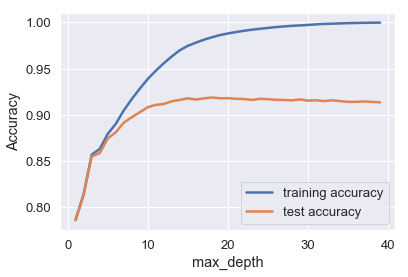

In [94]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(score["param_max_depth"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_max_depth"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**According to above plot, max_depth =10 is optimal**

#### Tuning min_samples_leaf

In [95]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [96]:
# scores of GridSearch CV
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_min_samples_leaf,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.38,0.00,0.91,0.97,5,{'min_samples_leaf': 5},1,0.87,0.97,0.91,...,0.92,0.97,0.91,0.97,0.92,0.96,0.12,0.00,0.02,0.00
1,1.10,0.00,0.89,0.92,25,{'min_samples_leaf': 25},2,0.87,0.92,0.89,...,0.90,0.92,0.90,0.92,0.91,0.92,0.05,0.00,0.01,0.00
2,1.05,0.00,0.89,0.90,45,{'min_samples_leaf': 45},3,0.87,0.91,0.88,...,0.90,0.90,0.89,0.90,0.90,0.90,0.09,0.00,0.01,0.00
3,1.02,0.00,0.88,0.90,65,{'min_samples_leaf': 65},4,0.87,0.90,0.88,...,0.89,0.90,0.89,0.90,0.89,0.90,0.16,0.00,0.01,0.00
4,0.93,0.00,0.88,0.89,85,{'min_samples_leaf': 85},5,0.87,0.90,0.89,...,0.89,0.89,0.88,0.89,0.89,0.89,0.06,0.00,0.01,0.00


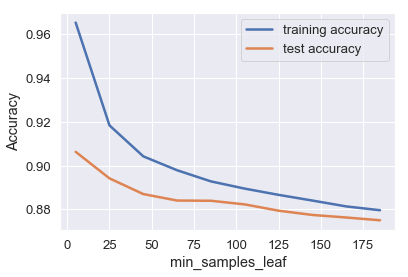

In [97]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

min_samples_leaf = 25 looks to be optimal

**Tuning min_samples_split**

In [98]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                    return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_split': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [99]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.51,0.00,0.91,0.99,5,{'min_samples_split': 5},1,0.88,0.99,0.92,...,0.92,0.99,0.92,0.99,0.92,0.99,0.11,0.00,0.02,0.00
1,1.75,0.00,0.90,0.96,25,{'min_samples_split': 25},2,0.87,0.97,0.91,...,0.91,0.96,0.91,0.96,0.91,0.96,0.24,0.00,0.02,0.00
2,1.44,0.00,0.90,0.95,45,{'min_samples_split': 45},3,0.87,0.95,0.91,...,0.91,0.95,0.90,0.94,0.91,0.94,0.07,0.00,0.01,0.00
3,1.49,0.01,0.90,0.94,65,{'min_samples_split': 65},4,0.87,0.94,0.90,...,0.91,0.94,0.90,0.93,0.91,0.93,0.12,0.00,0.01,0.00
4,1.41,0.00,0.90,0.93,85,{'min_samples_split': 85},5,0.87,0.93,0.90,...,0.91,0.93,0.90,0.93,0.90,0.93,0.06,0.00,0.02,0.00


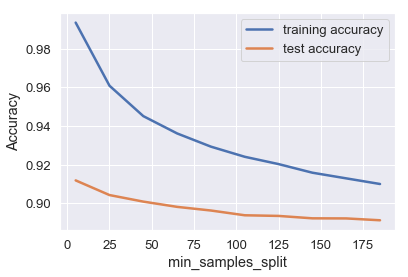

In [100]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

min_samples_leaf=50 looks optimal

In [101]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_lasso, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(25, 175, 50),
                         'min_samples_split': range(50, 150, 50)},
             verbose=1)

In [102]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Accuracy", grid_search.best_score_)


Best Accuracy 0.8961534910582987


In [103]:
print(grid_search.best_estimator_)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=50)


In [104]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=25,
                                  min_samples_split=50)
clf_gini.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=25, min_samples_split=50,
                       random_state=100)

In [105]:
# accuracy score
print ('Accuracy Score for Decision Tree Final Model :',clf_gini.score(X_test,y_test))

Accuracy Score for Decision Tree Final Model : 0.8511276524830574


In [106]:
model_summary_consol = model_summary_consol.append(pd.DataFrame([['Decision Tree', round(accuracy_score(y_test,y_pred1),2), round(recall_score(y_test,y_pred1),2), round(precision_score(y_test,y_pred1),2)]], columns = ['Model', 'Accuracy', 'Recall', 'Precision']),ignore_index=True)
model_summary_consol

,Model,Accuracy,Recall,Precision
0,Logistic Regression,0.82,0.81,0.28
1,Logistic Regression with PCA,0.82,0.82,0.29
2,Decision Tree,0.85,0.79,0.33


#### Summary - Decision Tress
* Getting around 87% accuracy 
* Confusion matix shows lot of false positives still exist.
* 31 Features were selected for Model Building

### Random Forest

Random Forest with Default Hyperparameters

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier()
model_rf.fit(X_lasso, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Randon Forest Accuracy with Default Hyperparameter',metrics.accuracy_score(y_test, prediction_test))

Randon Forest Accuracy with Default Hyperparameter 0.9284523941784246


In [108]:
print(classification_report(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8272
           1       0.55      0.66      0.60       729

    accuracy                           0.93      9001
   macro avg       0.76      0.81      0.78      9001
weighted avg       0.94      0.93      0.93      9001



In [109]:
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

[[7877  395]
 [ 249  480]]


#### Hyperparameter Tuning
- Tuning max_depth

In [110]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 20, 5)}, return_train_score=True,
             scoring='accuracy')

In [111]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.74,0.09,0.82,0.82,2,{'max_depth': 2},4,0.81,0.82,0.82,...,0.82,0.82,0.81,0.83,0.83,0.82,0.08,0.01,0.00,0.00
1,7.17,0.12,0.90,0.91,7,{'max_depth': 7},3,0.89,0.91,0.90,...,0.91,0.91,0.90,0.91,0.91,0.90,0.20,0.00,0.01,0.00
2,10.73,0.18,0.94,0.97,12,{'max_depth': 12},2,0.93,0.97,0.94,...,0.95,0.96,0.94,0.97,0.95,0.96,0.15,0.01,0.01,0.00
3,13.00,0.21,0.96,0.99,17,{'max_depth': 17},1,0.94,0.99,0.96,...,0.96,0.99,0.96,0.99,0.96,0.99,0.48,0.01,0.01,0.00


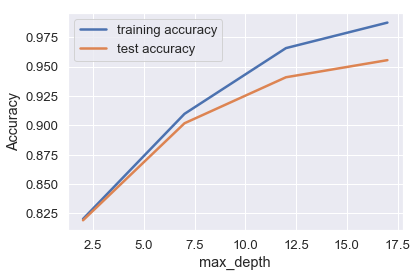

In [112]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Tuning min_samples_leaf**

In [113]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 10)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': range(50, 400, 10)},
             return_train_score=True, scoring='accuracy')

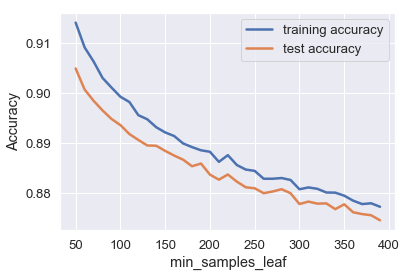

In [114]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Tuning min_samples_split**

In [115]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 500, 25)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_split': range(100, 500, 25)},
             return_train_score=True, scoring='accuracy')

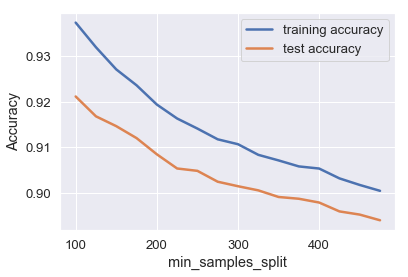

In [116]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Grid Search to Find Optimal Hyperparameters**

In [117]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 300, 100),
    'min_samples_split': range(200, 500, 100),
    'n_estimators': [500,700], 
    'max_features': [10,20,25]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=10,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=1000 ,
                                  oob_score = True, n_jobs = -1,
                                  random_state =50,
                                  max_features = 15,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

In [119]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,prediction_test))
print(confusion_matrix(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5493
           1       0.72      0.41      0.52       508

    accuracy                           0.94      6001
   macro avg       0.84      0.70      0.74      6001
weighted avg       0.93      0.94      0.93      6001

[[5414   79]
 [ 300  208]]


In [120]:
# accuracy score
print ('Accuracy Score for Random Forest Final Model :',metrics.accuracy_score(y_test, prediction_test))

Accuracy Score for Random Forest Final Model : 0.9368438593567738


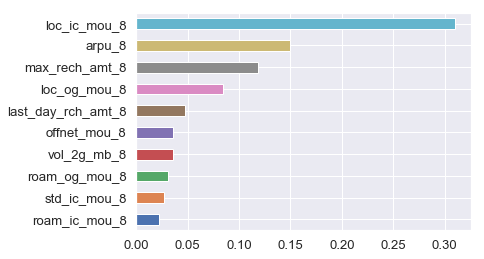

In [121]:
X = df
# Scaling all the variables to a range of 0 to 1
#from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

In [122]:
model_summary_consol = model_summary_consol.append(pd.DataFrame([['Random Forest', round(accuracy_score(y_test,prediction_test),2), round(recall_score(y_test,prediction_test),2), round(precision_score(y_test,prediction_test),2)]], columns = ['Model', 'Accuracy', 'Recall', 'Precision']),ignore_index=True)
model_summary_consol

,Model,Accuracy,Recall,Precision
0,Logistic Regression,0.82,0.81,0.28
1,Logistic Regression with PCA,0.82,0.82,0.29
2,Decision Tree,0.85,0.79,0.33
3,Random Forest,0.94,0.41,0.72


Observations:

* From random forest algorithm, Local Incoming for Month 8, Average Revenue Per Customer for Month 8 and Max Recharge Amount for Month 8 are the most important predictor variables to predict churn.

### ** Summary : Telecom Churn**
* Very Less Amount of High Value customers are churning which is a good service indicator
* Large no of Customers are new to Telecom Company and fall under < 5 Yr Tenure
* Std Outgoing Calls and Revenue Per Customer are strong indicators of Churn
* People with less than 4 Yrs of Tenure are more likely to Churn
* Behaviour of Volume Based Cost is not a strong indicator of Churn
* Max Recharge Amount could be a good Churn Indicator
* Random Forest is the best method to Predict Churn followed by Decision tree, other models too do a fair job
* Behaviour in Month 8 can be the base of Churn Analysis
* Local Incoming and Outgoing Calls for 8th Month and Average Revenue in 8th Month are strong indicators of Churn Behaviour